In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas

np.random.seed(42)

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

## Week 11B: Supervised Learning with Scikit-Learn
Nov 17, 2021


## Reminder

- [Final Project Groups](https://piazza.com/class/ksndf5uswe77dq?cid=81)
- [Final Project Dataset Ideas](https://piazza.com/class/ksndf5uswe77dq?cid=82)

## The plan for today

- Wrap up our money vs. happiness example
- Introduce decision trees and random forests
- Case study: Modeling housing prices in Philadelphia

## Supervised learning with scikit-learn

### Example: does money make people happier?

We'll load data compiled from two data sources:
- The *Better Life Index* from the [OECD's website](https://stats.oecd.org/index.aspx?DataSetCode=BLI)
- GDP per capita from the [IMF's website](https://www.imf.org/external/pubs/ft/weo/2016/01/weodata/weorept.aspx?pr.x=32&pr.y=8&sy=2015&ey=2015&scsm=1&ssd=1&sort=country&ds=.&br=1&c=512,668,914,672,612,946,614,137,311,962,213,674,911,676,193,548,122,556,912,678,313,181,419,867,513,682,316,684,913,273,124,868,339,921,638,948,514,943,218,686,963,688,616,518,223,728,516,558,918,138,748,196,618,278,624,692,522,694,622,142,156,449,626,564,628,565,228,283,924,853,233,288,632,293,636,566,634,964,238,182,662,453,960,968,423,922,935,714,128,862,611,135,321,716,243,456,248,722,469,942,253,718,642,724,643,576,939,936,644,961,819,813,172,199,132,733,646,184,648,524,915,361,134,362,652,364,174,732,328,366,258,734,656,144,654,146,336,463,263,528,268,923,532,738,944,578,176,537,534,742,536,866,429,369,433,744,178,186,436,925,136,869,343,746,158,926,439,466,916,112,664,111,826,298,542,927,967,846,443,299,917,582,544,474,941,754,446,698,666&s=NGDPDPC&grp=0&a)

In [3]:
# Load the data 
data = pd.read_csv("./data/gdp_vs_satisfaction.csv")
data.head()

Country  life_satisfaction  gdp_per_capita
0  Australia                7.3        50961.87
1    Austria                7.1        43724.03
2    Belgium                6.9        40106.63
3     Brazil                6.4         8670.00
4     Canada                7.4        43331.96

In [4]:
# Linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Model selection
from sklearn.model_selection import train_test_split

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

First step: set up the test/train split of input data:

In [5]:
# Do a 70/30 train/test split
train_set, test_set = train_test_split(data, test_size=0.3, random_state=42)

# Features
X_train = train_set['gdp_per_capita'].values
X_train = X_train[:, np.newaxis]

X_test = test_set['gdp_per_capita'].values
X_test = X_test[:, np.newaxis]

# Labels
y_train = train_set['life_satisfaction'].values
y_test = test_set['life_satisfaction'].values

## Where we left off: overfitting

As we increase the polynomial degree (add more and more polynomial features) two things happen:

1. Training accuracy goes way up 
1. Test accuracy goes way down
    
This is the classic case of overfitting — our model does not generalize well at all.

## Regularization to the rescue?

- The [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) adds regularization to the linear regression least squares model
- Parameter $\alpha$ determines the level of regularization
- Larger values of $\alpha$ mean stronger regularization — results in a "simpler" bestfit

**Remember, regularization penalizes large parameter values and complex fits**

Let's gain some intuition:

- Fix the polynomial degree to 3
- Try out alpha values of 0, 10, 100, and $10^5$
- Compare to linear fit (no polynomial features)


**Important**
- Baseline: linear model
    - This uses `LinearModel` and scales input features with `StandardScaler`
- Ridge regression: try multiple regularization strength values
    - Use a pipeline object to apply both a `StandardScaler` and `PolynomialFeatures(degree=3)` pre-processing to features

Set up a grid of GDP per capita points to make predictions for:

In [6]:
# The values we want to predict (ranging from our min to max GDP per capita)
gdp_pred = np.linspace(1e3, 1.1e5, 100)

# Sklearn needs the second axis!
X_pred = gdp_pred[:, np.newaxis]

Linear fit
Training Score = 0.4638100579740341
Test Score = 0.3595958514715957

alpha = 0
Training Score = 0.6458898101593085
Test Score = 0.5597457659851046

alpha = 10
Training Score = 0.5120282691427858
Test Score = 0.3833564210378835

alpha = 100
Training Score = 0.1815398751108913
Test Score = -0.05242399995626967

alpha = 100000.0
Training Score = 0.0020235571180508005
Test Score = -0.26129559971586125



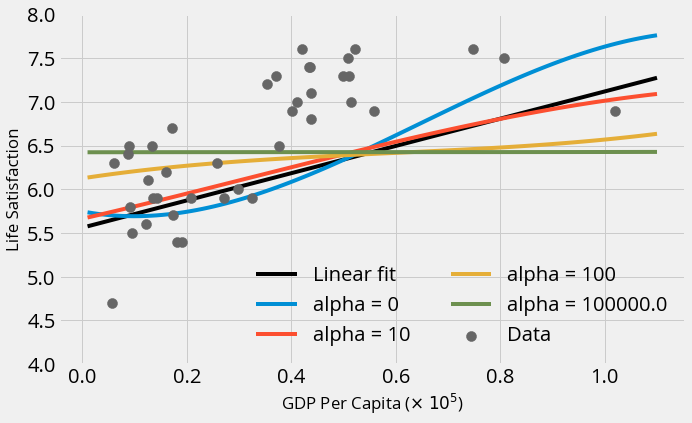

In [7]:
# Create a pre-processing pipeline
# This scales and adds polynomial features up to degree = 3
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(degree=3))

# BASELINE: Setup and fit a linear model (with scaled features)
linear = LinearRegression()
scaler = StandardScaler()
linear.fit(scaler.fit_transform(X_train), y_train)


with plt.style.context("fivethirtyeight"):

    fig, ax = plt.subplots(figsize=(10, 6))

    ## Plot the data
    ax.scatter(
        data["gdp_per_capita"] / 1e5,
        data["life_satisfaction"],
        label="Data",
        s=100,
        zorder=10,
        color="#666666",
    )

    ## Evaluate the linear fit
    print("Linear fit")
    training_score = linear.score(scaler.fit_transform(X_train), y_train)
    print(f"Training Score = {training_score}")

    test_score = linear.score(scaler.fit_transform(X_test), y_test)
    print(f"Test Score = {test_score}")
    print()


    ## Plot the linear fit
    ax.plot(
        X_pred / 1e5,
        linear.predict(scaler.fit_transform(X_pred)),
        color="k",
        label="Linear fit",
    )

    ## Ridge regression: linear model with regularization 
    # Plot the predicted values for each alpha
    for alpha in [0, 10, 100, 1e5]:
        print(f"alpha = {alpha}")

        # Create out Ridge model with this alpha
        ridge = Ridge(alpha=alpha)

        # Fit the model on the training set
        # NOTE: Use the pipeline that includes polynomial features
        ridge.fit(pipe.fit_transform(X_train), y_train)

        # Evaluate on the training set
        training_score = ridge.score(pipe.fit_transform(X_train), y_train)
        print(f"Training Score = {training_score}")

        # Evaluate on the test set
        test_score = ridge.score(pipe.fit_transform(X_test), y_test)
        print(f"Test Score = {test_score}")

        # Plot the ridge results
        y_pred = ridge.predict(pipe.fit_transform(X_pred))
        ax.plot(X_pred / 1e5, y_pred, label=f"alpha = {alpha}")

        print()

    # Plot formatting
    ax.legend(ncol=2, loc=0)
    ax.set_ylim(4, 8)
    ax.set_xlabel("GDP Per Capita ($\\times$ $10^5$)")
    ax.set_ylabel("Life Satisfaction")

## Takeaways

- As we increase alpha, the fits become "simpler" and coefficients get closer and closer to zero — a straight line!
- When alpha = 0 (no regularization), we get the same result as when we ran `LinearRegression()` with the polynomial features
- In this case, regularization doesn't improve the fit, and the base polynomial regression (degree=3) provides the best fit

## Recap: what we learned so far

- The LinearRegression model
- The test/train split and evaluation
- Feature engineering: scaling and creating polynomial features
- The Ridge model and regularization
- Creating Pipeline() objects


## How can we improve?

More feature engineering!

In this case, I've done the hard work for you and pulled additional country properties from the OECD's website.

In [8]:
data2 = pd.read_csv("./data/gdp_vs_satisfaction_more_features.csv")

In [9]:
data2.head()

Country  life_satisfaction  GDP per capita  Air pollution  \
0  Australia                7.3        50961.87            5.0   
1    Austria                7.1        43724.03           16.0   
2    Belgium                6.9        40106.63           15.0   
3     Brazil                6.4         8670.00           10.0   
4     Canada                7.4        43331.96            7.0   

   Employment rate  Feeling safe walking alone at night  Homicide rate  \
0             73.0                                 63.5            1.1   
1             72.0                                 80.6            0.5   
2             63.0                                 70.1            1.0   
3             61.0                                 35.6           26.7   
4             73.0                                 82.2            1.3   

   Life expectancy  Quality of support network  Voter turnout  Water quality  
0             82.5                        95.0           91.0           93.0  
1             81.7                        92.0           80.0           92.0  
2             81.5                        91.0           89.0           84.0  
3             74.8                        90.0           79.0           73.0  
4             81.9                        93.0           68.0           91.0

## Decision trees: a more sophisticated modeling algorithm

We'll move beyond simple linear regression and see if we can get a better fit.

A decision tree learns decision rules from the input features:

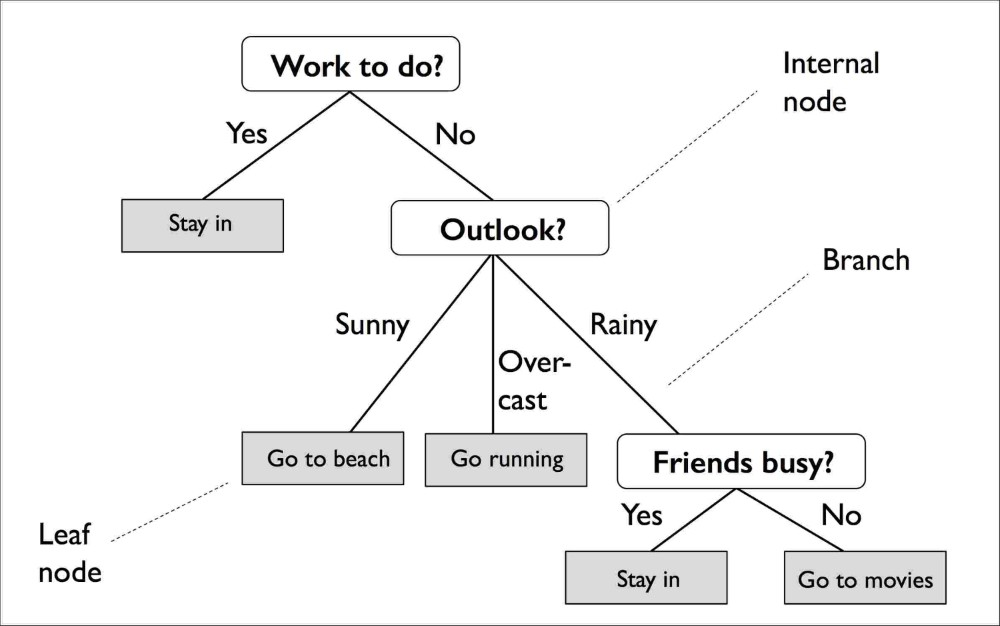</img>

## A decision tree classifier for the Iris data set


<img src=attachment:1_z4zWVweDtHJzq4Ky5eOAHg.png width=600></img>

[More info on the iris data set](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html)
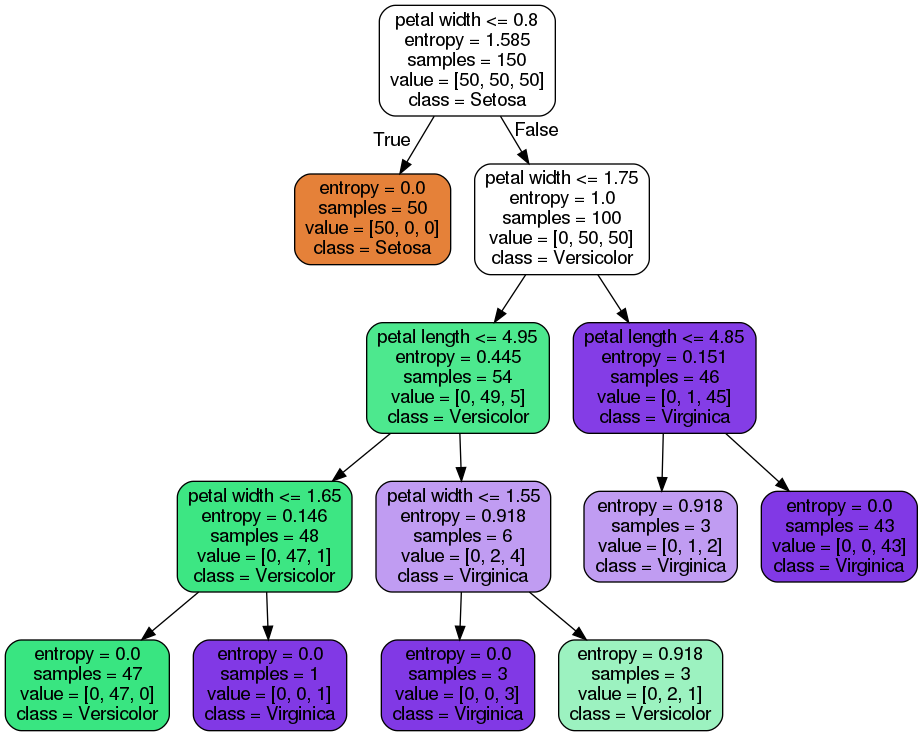

## Regression with decision trees is similar

For a specific corner of the input feature space, the decision tree predicts an output target value

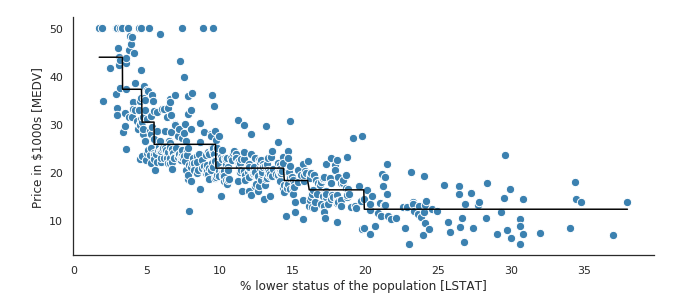</img>


## Decision trees suffer from overfitting

Decision trees can be very deep with many nodes — this will lead to overfitting your dataset! 

## Random forests: an *ensemble* solution to overfitting

- Introduces randomization into the fitting process to avoid overfitting
- Fits multiple decision trees on random subsets of the input data
- Avoids overfitting and leads to better overall fits

This is an example of *ensemble* learning: combining multiple estimators to achieve better overall accuracy than any one model could achieve

In [10]:
from sklearn.ensemble import RandomForestRegressor

Let's split our data into training and test sets again:

In [11]:
# Split the data 70/30
train_set, test_set = train_test_split(data2, test_size=0.3, random_state=42)

# the target labels
y_train = train_set["life_satisfaction"].values
y_test = test_set["life_satisfaction"].values

# The features
feature_cols = [col for col in data2.columns if col not in ["life_satisfaction", "Country"]]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

## Let's check for correlations in our input data

- Highly correlated input variables can skew the model fits and lead to worse accuracy
- Best to remove features with high correlations (rule of thumb: coefficients > 0.7 or 0.8, typically)

In [12]:
import seaborn as sns

<AxesSubplot:>

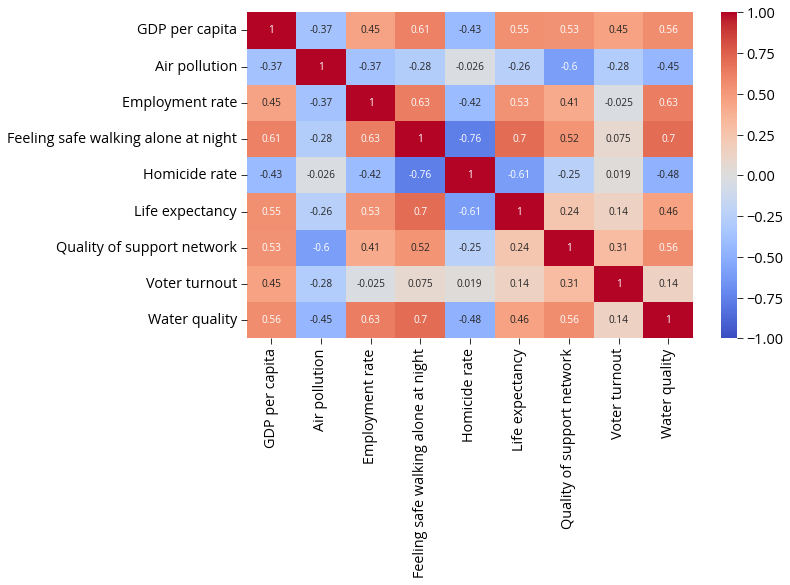

In [13]:
sns.heatmap(
    train_set[feature_cols].corr(), 
    cmap="coolwarm", 
    annot=True, 
    vmin=-1, 
    vmax=1
)

## Let's do some fitting...

**New:** `Pipelines` support models as the last step!

- Very useful for setting up reproducible machine learning analyses!
- The `Pipeline` behaves just like a model, but it runs the transformations beforehand
- Simplifies the analysis: now we can just call the `.fit()` function of the pipeline instead of the model

Establish a baseline with a linear model:

In [14]:
# Linear model pipeline with two steps
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Fit the pipeline
# NEW: This applies all of the transformations, and then fits the model
print("Linear regression")
linear_pipe.fit(X_train, y_train)

# NEW: Print the training score
training_score = linear_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# NEW: Print the test score
test_score = linear_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Linear regression
Training Score = 0.7553332657461678
Test Score = 0.647886559044683


Now fit a random forest:

In [15]:
# Random forest model pipeline with two steps
forest_pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, max_depth=2, random_state=42)
)

# Fit a random forest
print("Random forest")
forest_pipe.fit(X_train, y_train)

# Print the training score
training_score = forest_pipe.score(X_train, y_train)
print(f"Training Score = {training_score}")

# Print the test score
test_score = forest_pipe.score(X_test, y_test)
print(f"Test Score = {test_score}")

Random forest
Training Score = 0.8460559576380231
Test Score = 0.862756366860489


## Which variables matter the most?

Because random forests are an ensemble method with multiple estimators, the algorithm can learn which features help improve the fit the most.

- The *feature importances* are stored as the `feature_importances_` attribute
- Only available after calling `fit()`!

In [16]:
# What are the named steps?
forest_pipe.named_steps

{'standardscaler': StandardScaler(),
 'randomforestregressor': RandomForestRegressor(max_depth=2, random_state=42)}

In [17]:
# Get the forest model
forest_model = forest_pipe['randomforestregressor']

In [18]:
forest_model.feature_importances_

array([0.67746013, 0.0038663 , 0.13108609, 0.06579352, 0.00985913,
       0.01767323, 0.02635605, 0.00601776, 0.06188779])

In [19]:
# Make the dataframe
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": forest_model.feature_importances_}
).sort_values("Importance")

In [20]:
importance

Feature  Importance
1                        Air pollution    0.003866
7                        Voter turnout    0.006018
4                        Homicide rate    0.009859
5                      Life expectancy    0.017673
6           Quality of support network    0.026356
8                        Water quality    0.061888
3  Feeling safe walking alone at night    0.065794
2                      Employment rate    0.131086
0                       GDP per capita    0.677460

In [23]:
# Plot
importance.hvplot.barh(
    x="Feature", y="Importance", title="Does Money Make You Happier?"
)

:Bars   [Feature]   (Importance)

## Let's improve our fitting with *k*-fold cross validation

1. Break the data into a training set and test set
1. Split the training set into *k* subsets (or folds), holding out one subset as the test set
1. Run the learning algorithm on each combination of subsets, using the average of all of the runs to find the best fitting model parameters

For more information, see the [scikit-learn docs](https://scikit-learn.org/stable/modules/cross_validation.html)



<img src=attachment:grid_search_cross_validation.png width=600></img>
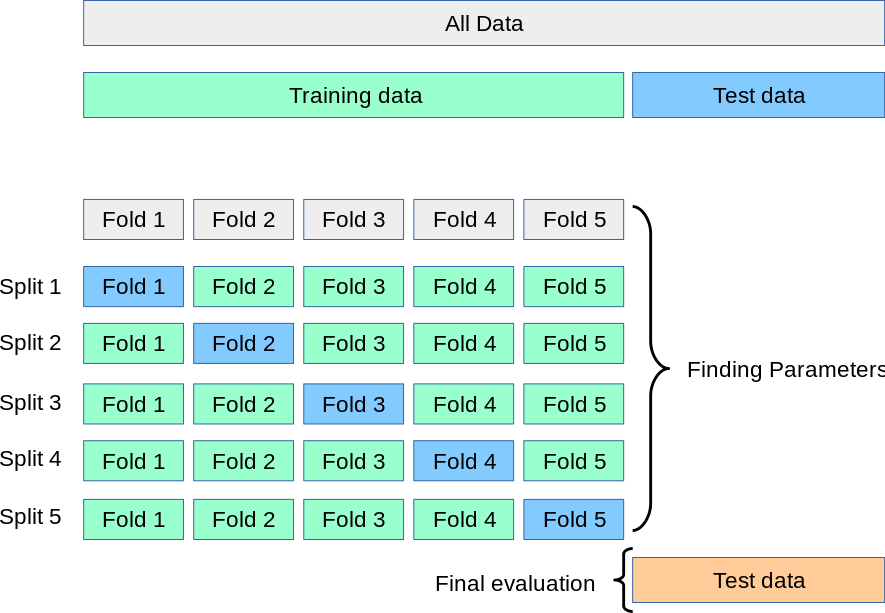

The [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score) function will automatically partition the training set into *k* folds, fit the model to the subset, and return the scores for each partition.

It takes a `Pipeline` object, the training features, and the training labels as arguments

In [24]:
from sklearn.model_selection import cross_val_score

In [25]:
cross_val_score?

## Let's do 3-fold cross validation

In [26]:
# Make a linear pipeline
linear_pipe = make_pipeline(StandardScaler(), LinearRegression())

# Run the 3-fold cross validation
scores = cross_val_score(
    linear_pipe,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [ 0.02064625 -0.84773581 -0.53652985]
Scores mean =  -0.4545398042994612
Score std dev =  0.35922474493059214


In [27]:
forest_pipe['randomforestregressor'].score?

Object `score` not found.


In [ ]:
forest_pipe['randomforestregressor'].score

In [28]:
forest_pipe['randomforestregressor'].score

<bound method RegressorMixin.score of RandomForestRegressor(max_depth=2, random_state=42)>

In [29]:
forest_pipe['randomforestregressor'].score

<bound method RegressorMixin.score of RandomForestRegressor(max_depth=2, random_state=42)>

In [30]:
forest_pipe['randomforestregressor'].score

<bound method RegressorMixin.score of RandomForestRegressor(max_depth=2, random_state=42)>

In [31]:
model = forest_pipe['randomforestregressor']

In [32]:
model.score?

In [33]:
# Make a random forest pipeline
forest_pipe = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 3-fold cross validation
scores = cross_val_score(
    forest_pipe,
    X_train,
    y_train,
    cv=3,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.51950656 0.78033403 0.66526384]
Scores mean =  0.655034812029183
Score std dev =  0.10672774411781198


## Takeaway: the random forest model is clearly more accurate

## Question: why did I choose to use 100 estimators in the RF model?

- In this case, I didn't have a good reason
- `n_estimators` is a model *hyperparameter*
- In practice, it's best to optimize the hyperparameters **and** the model parameters `(via the fit() method)`

**This is when cross validation becomes very important**

- Optimizing hyperparameters with a single train/test split means you are really optimizing based on your test set.
- If you use cross validation, a final test set will always be held in reserve to do a final evaluation.

## Enter GridSearchCV

A utility function that will:
- Iterate over a grid of hyperparameters
- Perform *k*-fold cross validation
- Return the parameter combination with the best overall score

[More info](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [34]:
from sklearn.model_selection import GridSearchCV

Let's do a search over the `n_estimators` parameter and the `max_depth` parameter:

In [35]:
# Create our regression pipeline
pipe = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))
pipe

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

# Make the grid of parameters to search
 
- **NOTE:** you must prepend the name of the pipeline step
- The syntax for parameter names is: 

> "[step name]__[parameter name]"

In [36]:
model_step = "randomforestregressor"
param_grid = {
    f"{model_step}__n_estimators": [5, 10, 15, 20, 30, 50, 100, 200],
    f"{model_step}__max_depth": [2, 5, 7, 9, 13, 21, 33, 51],
}

param_grid

{'randomforestregressor__n_estimators': [5, 10, 15, 20, 30, 50, 100, 200],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13, 21, 33, 51]}

In [37]:
# Create the grid and use 3-fold CV
grid = GridSearchCV(pipe, param_grid, cv=3)

# Run the search
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13,
                                                              21, 33, 51],
                         'randomforestregressor__n_estimators': [5, 10, 15, 20,
                                                                 30, 50, 100,
                                                                 200]})

In [38]:
# The best estimator
grid.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [39]:
# The best hyper parameters
grid.best_params_

{'randomforestregressor__max_depth': 7,
 'randomforestregressor__n_estimators': 100}

## Now let's evaluate!

We'll define a helper utility function to calculate the accuracy in terms of the mean absolute percent error

In [40]:
def evaluate(model, X_test, y_test):
    """
    Given a model and test features/targets, print out the 
    mean absolute error and accuracy
    """
    # Make the predictions
    predictions = model.predict(X_test)

    # Absolute error
    errors = abs(predictions - y_test)
    avg_error = np.mean(errors)

    # Mean absolute percentage error
    mape = 100 * np.mean(errors / y_test)

    # Accuracy
    accuracy = 100 - mape

    print("Model Performance")
    print(f"Average Absolute Error: {avg_error:0.4f}")
    print(f"Accuracy = {accuracy:0.2f}%.")

    return accuracy

### Linear model results

In [41]:
# Setup the pipeline
linear = make_pipeline(StandardScaler(), LinearRegression())

# Fit on train set
linear.fit(X_train, y_train)

# Evaluate on test set
evaluate(linear, X_test, y_test)

Model Performance
Average Absolute Error: 0.3281
Accuracy = 94.93%.


94.92864894582036

### Random forest results with default parameters

In [42]:
# Initialize the pipeline
base_model = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=42))

# Fit the training set
base_model.fit(X_train, y_train)

# Evaluate on the test set
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Absolute Error: 0.2291
Accuracy = 96.47%.


### The random forest model with the optimal hyperparameters

Small improvement!

In [43]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

# What's the improvement?
improvement = 100 * (random_accuracy - base_accuracy) / base_accuracy
print(f'Improvement of {improvement:0.4f}%.')

Model Performance
Average Absolute Error: 0.2288
Accuracy = 96.47%.
Improvement of 0.0025%.


## Recap

- Decision trees and random forests
- Cross validation with `cross_val_score`
- Optimizing hyperparameters with `GridSearchCV`
- Feature importances from random forests

## Part 2: Modeling residential sales in Philadelphia

In this part, we'll use a random forest model and housing data from the Office of Property Assessment to predict residential sale prices in Philadelphia

## Machine learning models are increasingly common in the real estate industry
  - [Airbnb recommends pricing to hosts](https://spectrum.ieee.org/computing/software/the-secret-of-airbnbs-pricing-algorithm)
  - [Trulia converts house photos to house features](https://www.trulia.com/blog/tech/image-recognition/)
  - [Zillow's Zestimate](https://www.zillow.com/research/zestimate-forecast-methodology/)

## The hedonic approach to housing prices

- An econometric approach
- Deconstruct housing price to the value of each of its parts
- Captures the "price premium" consumers are willing to pay for an extra bedroom or garage

## What contributes to the price of a house?

- Property characteristics, e.g, size of the lot and the number of bedrooms
- Neighborhood features based on amenities or disamenities, e.g., access to transit or exposure to crime
- Spatial component that captures the tendency of housing prices to depend on the prices of neighboring homes

**Note:** We'll focus on the first two components in this analysis (and in assignment #7)

## Why are these kinds of models important?

- They are used widely by cities to perform property assessment valuation
    - Train a model on recent residential sales
    - Apply the model to the entire residential housing stock to produce assessments
- Biases in the algorithmic models have important consequences for city residents


**Too often, these models perpetuate inequality: low-value homes are over-assessed and high-value homes are under-assessed**

## Philadelphia's assessments are...not good

- [City Controller analysis of property assessments in Philadelphia](https://controller.phila.gov/philadelphia-audits/property-assessment-review/)
- [Urban Spatial paper on algorithmic fairness with a case study on modeling Philadelphia's home values](https://urbanspatial.github.io/AlgorithmicFairness_ACodebasedPrimerForPublicSectorDataScientists)

## Data from the Office of Property Assessment

Let's download data for properties in Philadelphia that had their last sale during 2019.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [44]:
import carto2gpd

In [45]:
# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# The table name
table_name = "opa_properties_public"

# Only pull 2019 sales for single family residential properties
where = "sale_date >= '2019-01-01' and sale_date < '2020-01-01' and category_code_description = 'Single Family'"

# Run the query
salesRaw = carto2gpd.get(carto_url, table_name, where=where)

In [46]:
salesRaw.head()

geometry  cartodb_id assessment_date basements  \
0  POINT (-75.14368 39.95277)        1459            None      None   
1  POINT (-75.14368 39.95277)        1499            None      None   
2  POINT (-75.15706 39.94570)        1622            None      None   
3  POINT (-75.12452 39.99359)        4851            None      None   
4  POINT (-75.15231 39.94590)        5888            None      None   

             beginning_point book_and_page building_code  \
0                       None       3530281         590     
1                       None       3530426         570     
2                       None       3584346         570     
3  100' N CAMBRIA ST               3536584         O30     
4                       None       3597520         590     

  building_code_description category_code category_code_description  ...  \
0  RES CONDO 5+ STY MASONRY            1              Single Family  ...   
1   RES CONDO 4 STY MASONRY            1              Single Family  ...   
2   RES CONDO 4 STY MASONRY            1              Single Family  ...   
3         ROW 2 STY MASONRY            1              Single Family  ...   
4  RES CONDO 5+ STY MASONRY            1              Single Family  ...   

   unit utility view_type year_built  year_built_estimate  zip_code  zoning  \
0   3D1    None         I       2006                    Y     19106    CMX3   
1    A1    None         I       2006                    Y     19106    CMX3   
2     1    None         I       1870                    Y     19107     RM1   
3  None    None         I       1930                    Y     19134    RSA5   
4  2017    None         I       1973                    Y     19106    RMX3   

  pwd_parcel_id         pin  objectid  
0          None  1001099633  26747709  
1          None  1001099741  26747634  
2          None  1001495819  26747792  
3          None  1001468897  26752058  
4          None  1001553933  26753541  

[5 rows x 79 columns]

In [47]:
len(salesRaw)

24739

## The OPA is messy

**Lots** of missing data.

We can use the [missingno](https://github.com/ResidentMario/missingno) package to visualize the missing data easily.

In [48]:
import missingno as msno

In [49]:
# We'll visualize the first half of columns
# and then the second half
ncol = len(salesRaw.columns)

fields1 = salesRaw.columns[:ncol//2]
fields2 = salesRaw.columns[ncol//2:]

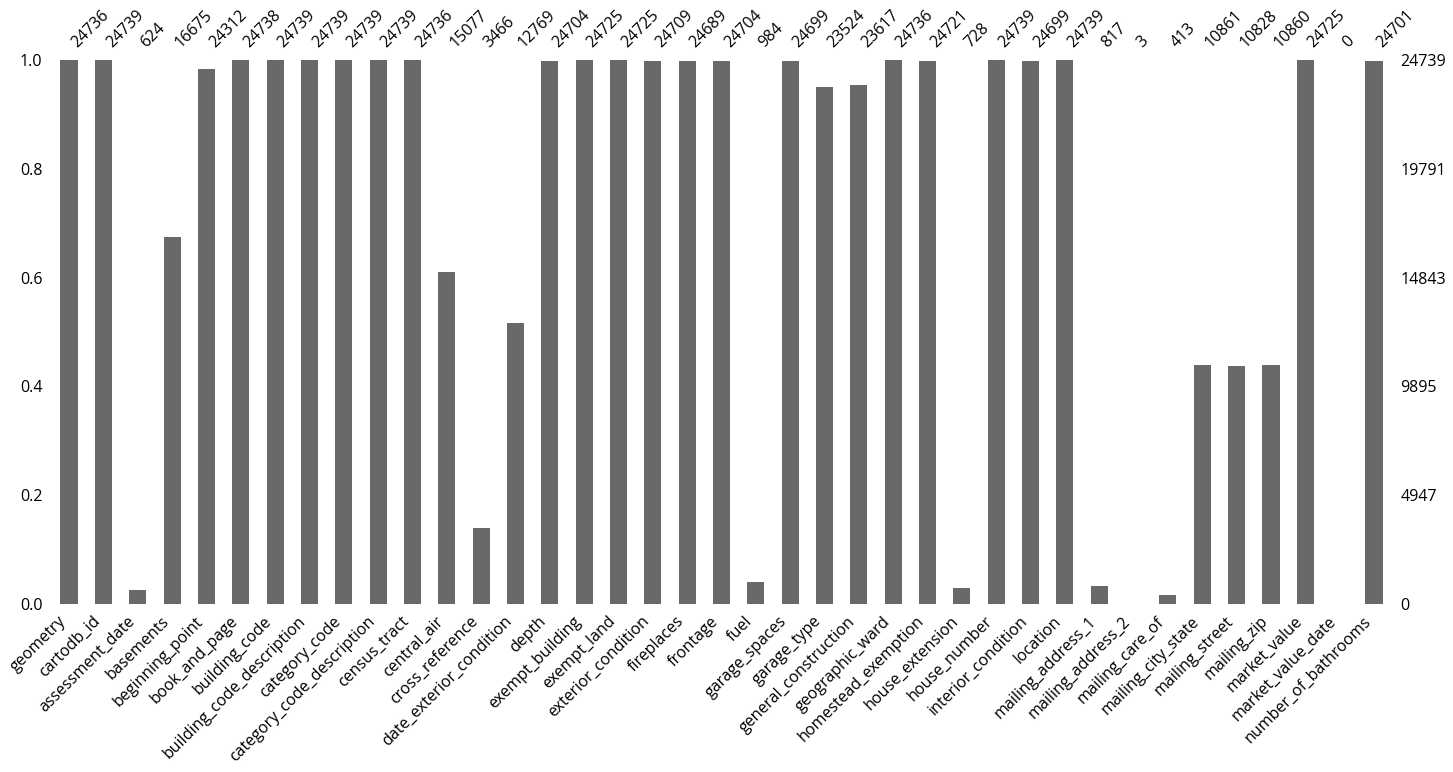

In [50]:
# The first half of columns
msno.bar(salesRaw[fields1]);

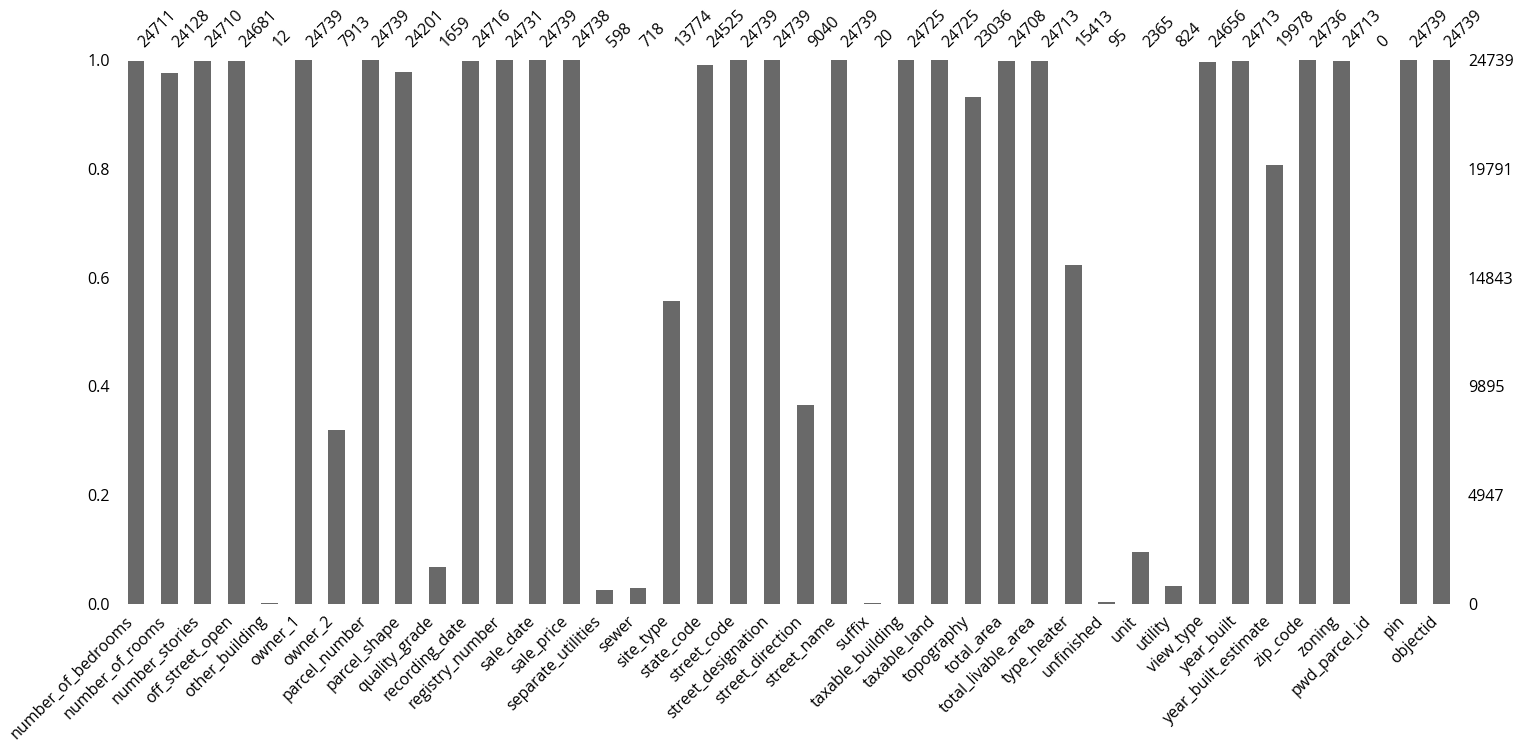

In [51]:
# The second half of columns
msno.bar(salesRaw[fields2]);

In [52]:
# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "zip_code",
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols].dropna()

# Trim zip code to only the first five digits
sales['zip_code'] = sales['zip_code'].astype(str).str.slice(0, 5)

In [53]:
# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [54]:
len(sales)

19037

## Let's focus on numerical features only first

In [55]:
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

# The features
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

In [56]:
# Make a random forest pipeline
forest = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.34996394 0.25083697 0.33091547 0.31962958 0.29996041 0.31076306
 0.30812836 0.31379612 0.26855678 0.33484882]
Scores mean =  0.3087399500171242
Score std dev =  0.02840067302844511


In [57]:
# Fit on the training data
forest.fit(X_train, y_train)

# What's the test score?
forest.score(X_test, y_test)

0.30738291494682013

### Test score slightly better 

Model appears to generalize reasonably well!

**Note:** we should also be optimizing hyperparameters to see if we can find additional improvements!

## Which variables were most important?

In [58]:
# Extract the regressor from the pipeline
regressor = forest["randomforestregressor"]

In [59]:
# Create the data frame of importances
importance = pd.DataFrame(
    {"Feature": feature_cols, "Importance": regressor.feature_importances_}
)
importance.hvplot.barh(x="Feature", y="Importance")

:Bars   [Feature]   (Importance)

## More next lecture...

## That's it!

- Assignment #6 due week from today (11/24)
- Next week: more predictive modeling with scikit-learn looking at bikeshare data
- Last two weeks: transitioning to the web with web-based visualization